In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
year_cut = 2010
score_cut = 0.9

In [11]:
df = pd.read_csv('data/dga_data.csv')
df['first_pub_year'] = df['first_pub_year'].apply(lambda x: np.nan if x in [None, "None"] else float(x))
df['last_pub_year'] = df['last_pub_year'].apply(lambda x: np.nan if x in [None, "None"] else float(x))
# filter on score
df = df[df['score'] >= score_cut]
# check whether we can operate time cut
if df['first_pub_year'].isna().sum()/len(df) > 0.3:
    time_cut = False
    print('only ', round(1-df['first_pub_year'].isna().sum()/len(df),2),'of associations have record publiacation year')

# split train and test genes
if time_cut:
    print('year cut is ', year_cut)
    df.dropna(subset='first_pub_year')
    train_genes = df[df['first_pub_year']>= year_cut]['gene_id']
    test_genes = df[df['first_pub_year']< year_cut]['gene_id']
else:
    print('no sufficient information, random split')
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_size = int(0.8 * len(df))  # Calculate 80% index
    train_genes = df['gene_id'][:train_size]  # First 80%
    test_genes = df['gene_id'][train_size:]

only  0.31 of associations have record publiacation year
no sufficient information, random split


In [19]:
df

,disease_id,disease_name,gene_id,score,first_pub_year,last_pub_year,ei,dsi,dpi
0,Cancer,Breast,IFNG,0.90,NaN,NaN,0.909,0.270,1.000
1,Cancer,Breast,SOD2,0.90,NaN,NaN,0.895,0.353,1.000
2,Cancer,Breast,TP53,1.00,2010.0,2019.0,0.898,0.256,0.957
3,Cancer,Breast,AKT1,0.95,2007.0,2007.0,0.953,0.283,0.957
4,Cancer,Breast,GSTM1,0.90,NaN,NaN,0.754,0.368,1.000
5,Cancer,Breast,VDR,0.90,NaN,NaN,0.858,0.336,0.957
6,Cancer,Breast,PTEN,1.00,2018.0,2019.0,0.927,0.290,0.913
7,Cancer,Breast,CTSD,0.90,NaN,NaN,0.919,0.418,0.913
8,Cancer,Breast,IL6,0.90,NaN,NaN,0.910,0.233,0.957
9,Cancer,Breast,CAV1,0.95,NaN,NaN,0.938,0.375,0.913


In [ ]:
import requests
from transformers import pipeline
from tqdm import tqdm
import re

# Step 1: Function to retrieve PubMed abstracts for a given query
def get_pubmed_abstracts(gene, disease, max_results=100):
    query = f"{gene} AND {disease}"
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax={max_results}&retmode=json"
    response = requests.get(url)
    pmids = response.json()["esearchresult"]["idlist"]

    abstracts = []
    for pmid in tqdm(pmids, desc="Fetching abstracts"):
        abstract_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={pmid}&retmode=text&rettype=abstract"
        abstract = requests.get(abstract_url).text
        abstracts.append((pmid, abstract))

    return abstracts

# Step 2: Load BioBERT NER model
ner_model = pipeline("ner", model="dmis-lab/biobert-v1.1", tokenizer="dmis-lab/biobert-v1.1")


# Step 3: Function to find sentences with both exact gene and disease mentions
def find_gene_disease_mentions(abstracts, gene, disease):
    mentions = []
    disease_pattern = re.compile(rf"\b{re.escape(disease)}\b", re.IGNORECASE)
    gene_pattern = re.compile(rf"\b{re.escape(gene)}\b", re.IGNORECASE)

    for pmid, abstract in abstracts:
        sentences = abstract.split(". ")
        for sentence in sentences:
            if gene_pattern.search(sentence) and disease_pattern.search(sentence):
                mentions.append((pmid, sentence))
    return mentions


# Step 4: Extract earliest publication year and print PMID
def get_first_publication_year(mentions):
    years = []
    pmid_year_map = {}

    for pmid, _ in mentions:
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={pmid}&retmode=json"
        response = requests.get(url)
        pub_date = response.json()["result"][str(pmid)]["pubdate"]
        year = pub_date.split()[0]
        years.append(int(year))
        pmid_year_map[pmid] = int(year)

    if years:
        earliest_year = min(years)
        earliest_pmid = [pmid for pmid, year in pmid_year_map.items() if year == earliest_year][0]
        return earliest_year, earliest_pmid
    else:
        return None, None

# Step 5: Main function
def main(gene, disease):

    print("\nFetching PubMed abstracts...")
    abstracts = get_pubmed_abstracts(gene, disease)

    print("\nFinding gene-disease mentions...")
    mentions = find_gene_disease_mentions(abstracts, gene, disease)

    if mentions:
        print("\nExtracting earliest publication year...")
        first_year, first_pmid = get_first_publication_year(mentions)
        print(f"\nThe earliest publication year for {gene} and {disease} is: {first_year}")
        print(f"Reference PMID: {first_pmid}")
    else:
        print("\nNo mentions of the gene-disease association were found.")

# Run the script
if __name__ == "__main__":
    main('IFNG','breast cancer')



c:\Users\ZZY\.conda\envs\rescal\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Fetching PubMed abstracts...


Fetching abstracts: 100%|██████████| 100/100 [01:18<00:00,  1.27it/s]



Finding gene-disease mentions...

Extracting earliest publication year...

The earliest publication year for IFNG and breast cancer is: 2018
Reference PMID: 30336781


In [20]:
# Step 1: Function to retrieve PubMed abstracts for multiple genes and one disease
def get_pubmed_abstracts(genes, disease, max_results=100):
    query = f"({' OR '.join(genes)}) AND \"{disease}\""
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax={max_results}&retmode=json"
    response = requests.get(url)
    pmids = response.json()["esearchresult"]["idlist"]

    abstracts = []
    for pmid in tqdm(pmids, desc="Fetching abstracts"):
        abstract_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={pmid}&retmode=text&rettype=abstract"
        abstract = requests.get(abstract_url).text
        abstracts.append((pmid, abstract))

    return abstracts

# Step 2: Load BioBERT NER model
ner_model = pipeline("ner", model="dmis-lab/biobert-v1.1", tokenizer="dmis-lab/biobert-v1.1")

# Step 3: Function to find sentences with both exact gene and disease mentions
def find_mentions(abstracts, gene, disease):
    mentions = []
    disease_pattern = re.compile(rf"\b{re.escape(disease)}\b", re.IGNORECASE)
    gene_pattern = re.compile(rf"\b{re.escape(gene)}\b", re.IGNORECASE)

    for pmid, abstract in abstracts:
        sentences = abstract.split(". ")
        for sentence in sentences:
            if gene_pattern.search(sentence) and disease_pattern.search(sentence):
                mentions.append((pmid, sentence))
    return mentions

# Step 4: Extract earliest publication year
def get_first_publication_year(mentions):
    years = []
    pmid_year_map = {}

    for pmid, _ in mentions:
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={pmid}&retmode=json"
        response = requests.get(url)
        pub_date = response.json()["result"][str(pmid)]["pubdate"]
        year = pub_date.split()[0]
        years.append(int(year))
        pmid_year_map[pmid] = int(year)

    if years:
        earliest_year = min(years)
        earliest_pmid = [pmid for pmid, year in pmid_year_map.items() if year == earliest_year][0]
        return earliest_year, earliest_pmid
    else:
        return None, None

# Step 5: Main function
def main(genes,disease):

    print("\nFetching PubMed abstracts...")
    abstracts = get_pubmed_abstracts(genes, disease)

    result = {}
    for gene in genes:
        mentions = find_mentions(abstracts, gene.strip(), disease)
        if mentions:
            first_year, first_pmid = get_first_publication_year(mentions)
            result[gene.strip()] = (first_year, first_pmid)
        else:
            result[gene.strip()] = ("No mentions found", None)

    # Print the results
    print("\nEarliest publication years for each gene:")
    for gene, (year, pmid) in result.items():
        print(f"{gene}: Year: {year}, PMID: {pmid}")

# Run the script
if __name__ == "__main__":
    main(['IFNG','SOD2','TP53','AKT1','GSTM1'],'Breast Cancer')


c:\Users\ZZY\.conda\envs\rescal\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Fetching PubMed abstracts...


Fetching abstracts: 100%|██████████| 100/100 [01:19<00:00,  1.27it/s]



Earliest publication years for each gene:
IFNG: Year: 2024, PMID: 39736012
SOD2: Year: No mentions found, PMID: None
TP53: Year: 2024, PMID: 39734593
AKT1: Year: 2024, PMID: 39633517
GSTM1: Year: No mentions found, PMID: None


In [23]:
import requests
from transformers import pipeline
from tqdm import tqdm

# Step 1: Function to retrieve PubMed abstracts for multiple genes and one disease
def get_pubmed_abstracts(genes, disease, max_results=1000):
    query = f"({' OR '.join(genes)}) AND \"{disease}\""
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax={max_results}&retmode=json"
    response = requests.get(url)
    pmids = response.json()["esearchresult"]["idlist"]

    abstracts = []
    for pmid in tqdm(pmids, desc="Fetching abstracts"):
        abstract_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={pmid}&retmode=text&rettype=abstract"
        abstract = requests.get(abstract_url).text
        abstracts.append((pmid, abstract))

    return abstracts

# Step 2: Load BioBERT NER model
ner_model = pipeline("ner", model="dmis-lab/biobert-v1.1", tokenizer="dmis-lab/biobert-v1.1")

# Step 3: Function to find mentions in abstracts
def find_mentions(abstracts, gene, disease):
    mentions = []
    for pmid, abstract in abstracts:
        sentences = abstract.split(". ")
        for sentence in sentences:
            if gene.lower() in sentence.lower() and disease.lower() in sentence.lower():
                mentions.append((pmid, sentence))
    return mentions

# Step 4: Extract earliest publication year
def get_first_publication_year(mentions):
    years = []
    pmid_year_map = {}

    for pmid, _ in mentions:
        url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=pubmed&id={pmid}&retmode=json"
        response = requests.get(url)
        pub_date = response.json()["result"][str(pmid)]["pubdate"]
        year = pub_date.split()[0]
        years.append(int(year))
        pmid_year_map[pmid] = int(year)

    if years:
        earliest_year = min(years)
        earliest_pmid = [pmid for pmid, year in pmid_year_map.items() if year == earliest_year][0]
        return earliest_year, earliest_pmid
    else:
        return None, None

# Step 5: Main function
def main(genes, disease):

    print("\nFetching PubMed abstracts...")
    abstracts = get_pubmed_abstracts(genes, disease)

    result = {}
    for gene in genes:
        mentions = find_mentions(abstracts, gene.strip(), disease)
        if mentions:
            first_year, first_pmid = get_first_publication_year(mentions)
            result[gene.strip()] = (first_year, first_pmid)
        else:
            result[gene.strip()] = ("No mentions found", None)

    # Print the results
    print("\nEarliest publication years for each gene:")
    for gene, (year, pmid) in result.items():
        print(f"{gene}: Year: {year}, PMID: {pmid}")

# Run the script
if __name__ == "__main__":
    main(['IFNG','SOD2','TP53','AKT1','GSTM1'],'Breast Cancer')


Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.



Fetching PubMed abstracts...


Fetching abstracts: 100%|██████████| 1000/1000 [13:12<00:00,  1.26it/s]



Earliest publication years for each gene:
IFNG: Year: 2021, PMID: 34835178
SOD2: Year: 2022, PMID: 36010852
TP53: Year: 1993, PMID: 20301488
AKT1: Year: 2021, PMID: 34981469
GSTM1: Year: 2021, PMID: 34912688


(array([1., 0., 0., 0., 0., 2., 3., 3., 2., 1.]),
 array([1969. , 1973.9, 1978.8, 1983.7, 1988.6, 1993.5, 1998.4, 2003.3,
        2008.2, 2013.1, 2018. ]),
 <BarContainer object of 10 artists>)

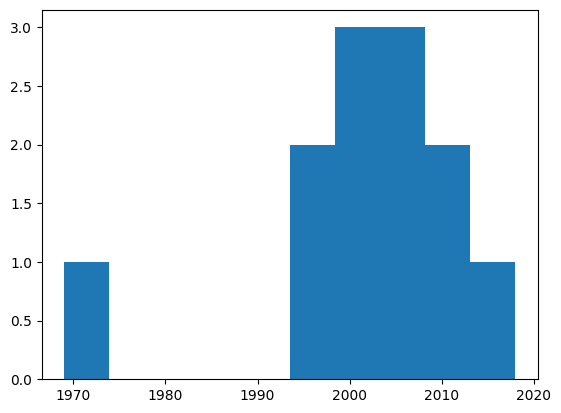

In [62]:
plt.hist(df['first_pub_year'])

In [ ]:
### why DisGeNET return NONE value of publiacation year?
### or use GPT API
### or use other text model extract information from title and abstract

In [22]:
### PPI features from node2vec
from pecanpy import pecanpy as node2vec

def Runnode2vec(filepath):
    n2v = node2vec.SparseOTF(p=1, q=1, workers=4, verbose=True)

    edge_list = n2v.read_edg(filepath, weighted=False, directed=False)
    emd = n2v.embed(dim=128, num_walks=10, walk_length=80, window_size=10, epochs=10)

    n2v_emd = pd.DataFrame(emd, n2v.nodes)

    n2v_emd.columns = ['network_' + str(col) for col in n2v_emd.columns]

    n2v_emd = n2v_emd.reset_index().rename(columns={"index":"gene_id"})

    return n2v_emd

In [23]:
ppi_features = Runnode2vec('data/edge_list.txt')
ppi_features.to_csv('data/ppi_emb.csv')

  0%|          | 0/181340 [00:00<?, ?it/s]

In [25]:
ppi_features

,gene,network_0,network_1,network_2,network_3,network_4,network_5,network_6,network_7,network_8,...,network_118,network_119,network_120,network_121,network_122,network_123,network_124,network_125,network_126,network_127
0,ARF5,-0.272194,-0.494542,0.023546,-0.041526,-0.029522,0.014231,-0.019696,0.345664,0.423864,...,0.567657,0.308274,0.115733,-0.205066,-0.077890,0.039782,-0.175998,0.229868,0.191000,-0.132395
1,NT5E,-0.307922,-0.282340,-0.165575,0.083201,-0.269015,-0.067329,-0.335849,0.229356,0.020818,...,0.050262,-0.025052,0.191767,-0.065536,0.230610,0.260587,-0.453608,0.136369,-0.239785,0.206882
2,DUSP3,-0.250936,0.150215,-0.118670,0.528412,-0.355529,0.036796,0.100395,0.218170,-0.189702,...,0.233765,-0.376560,-0.414672,-0.161881,0.350581,0.256244,0.208971,-0.107611,-0.531272,-0.169868
3,ARFGAP2,-0.303094,-0.240133,0.679699,-0.017372,-0.181280,0.462951,0.067849,0.492243,0.251070,...,0.403235,0.530557,0.196642,-0.382719,-0.077214,0.337930,-0.195109,0.176737,0.376933,-0.079878
4,ERP44,-0.025310,-0.316352,0.207233,-0.043206,0.150528,0.078218,-0.205096,0.079418,0.053247,...,0.529535,-0.004062,-0.161302,-0.300672,0.377090,0.312984,-0.098267,0.250333,0.132548,-0.149044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18129,CALHM3,-0.129011,-0.578701,0.176519,-0.095685,-0.451573,0.349254,0.274933,-0.594157,0.252270,...,0.731814,0.014886,0.187616,0.008970,-0.210153,0.196151,0.076331,0.421364,0.106469,0.062746
18130,FCRL6,-0.393430,-0.301189,0.381336,-0.379768,-0.519702,0.203204,-0.328101,0.277964,0.271354,...,-0.074853,-0.405306,0.509736,-0.093080,-0.261364,0.839658,-0.362342,-0.125555,0.222473,-0.129752
18131,TMEM26,0.184399,-0.496310,0.503457,-0.363867,-0.068349,-0.110082,-0.513597,0.007850,-0.573171,...,0.459767,-0.212599,-0.278405,-0.692284,0.214881,0.637033,-0.124449,0.526915,-0.972684,-0.091948
18132,MYMX,0.225966,-0.548683,0.567897,-0.441428,-0.084062,-0.131734,-0.572699,0.019236,-0.641038,...,0.486737,-0.204318,-0.300830,-0.790257,0.223485,0.704652,-0.137031,0.557378,-1.080846,-0.094010


In [26]:
ppi_features = ppi_features.rename(columns={'gene': 'gene_id'})
train_genes = pd.merge(train_genes, ppi_features, on='gene_id', how='inner')
test_genes = pd.merge(test_genes, ppi_features, on='gene_id', how='inner')

In [28]:
len(train_genes),len(test_genes)

(541, 137)

In [30]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import ParameterGrid
import matplotlib.font_manager

In [38]:
outliers = ppi_features[~ppi_features['gene_id'].isin(df['gene_id'])]

In [33]:
clf = OneClassSVM(nu=0.1,kernel='rbf',gamma=0.1)
clf.fit(train_genes.iloc[:, 1:])

OneClassSVM(gamma=0.1, nu=0.1)

In [ ]:
### try other kernels, numerical problems might happen when using rbf, if so, add small number to the 斜线
### SVM, C value, nu value
### nested CV, 5 outler and 3 inner

In [40]:
y_pred_train = clf.predict(train_genes.iloc[:, 1:])
y_pred_test = clf.predict(test_genes.iloc[:, 1:])
y_pred_outlier = clf.predict(outliers.iloc[:, 1:])

In [42]:
X_train = train_genes.iloc[:, 1:]
X_test = test_genes.iloc[:, 1:]
X_outliers = outliers.iloc[:, 1:]

In [44]:
y_score_train = clf.score_samples(X_train)
y_score_test = clf.score_samples(X_test)
y_score_outliers = clf.score_samples(X_outliers)
 
# Calculate the distance from the sample to the hyperplane, 
# with positive and negative signs, indicating that it is in the hyperplane, and negative signs indicate that it is outside the hyperplane
y_deci_train = clf.decision_function(X_train)
y_deci_test = clf.decision_function(X_test)
y_deci_outliers = clf.decision_function(X_outliers)
 
# wrong number
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outlier[y_pred_outlier == 1].size



In [45]:
n_error_train,n_error_test,n_error_outliers

(54, 21, 13054)

In [ ]:
# One-Class SVM parem
param_grid = {
    'nu': [0.01, 0.05, 0.1],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['auto', 'scale']
}

# find bes param
best_score = np.inf
best_params = None

for g in ParameterGrid(param_grid):
    model = OneClassSVM(**g)
    model.fit(X_train)
    scores = model.decision_function(X_val)
    score = -scores.mean()
    if score < best_score:
        best_score = score
        best_params = g

print("Best parameters:", best_params)

oc_svm_best = OneClassSVM(**best_params)